# Chapter 2: First Neural Network with PyTorch

#### Imports

In [37]:
# importing the neccesary libraries

# operating system 
import os 

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns 

# linalg
import numpy as np 

# dataframes 
import pandas as pd

# splitting datasets 
from sklearn.model_selection import train_test_split

# metrics - CM + report 
from sklearn.metrics import confusion_matrix, classification_report

# neural nets 
import torch 
import torch.nn as nn
import torch.optim as optim 

# functional torch 
import torch.nn.functional as F

# colored print statements :D
import termcolor
from termcolor import colored

#### Loading Data

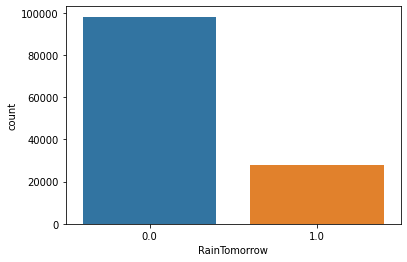

0.0    0.778723
1.0    0.221277
Name: RainTomorrow, dtype: float64


In [2]:
# lets load the data located in the data folder 
DATA_PATH = '../data/Chapter_2/weatherAUS.csv'
# load into df 
df = pd.read_csv(DATA_PATH)
# lets look at the shape of it 
#print(df.shape)
# lets look at the columns 
#print(df.columns)

# The book suggests keeping these columns: 
# cols=['Rainfall','Humidity3pm','Pressure9am','RainToday','RainTomorrow']
# I will use the first and the last two only the rest I change
cols = ['Rainfall','WindSpeed9am','WindSpeed3pm','Pressure3pm','RainToday','RainTomorrow']
# lets index the df with the respective cols
df = df[cols]
# lets look at the dtypes of the columns 
#print(df.dtypes) # we see that 3 are objects, let's look at them

# we see WindDir3PM is about the direction, so let's remove that from the orig
# and replace with windspeed 9 am 
# now we can replace the No and Yes with numbers 
d = {"No":0,"Yes":1}
df['RainToday'].replace(d, inplace=True)
df['RainTomorrow'].replace(d, inplace=True)

# looking at nanas 
#df.isna().sum() # plenty of NaNs, lets drop them 

# dropping the nans 
df = df.dropna(how='any')

# lets visualize the data 
sns.countplot(x = df.RainTomorrow);
plt.show()
# how many of the instances are for rain tomorrow?
print(df.RainTomorrow.value_counts()/df.shape[0]) # high class imbalance

#### Splitting Data

In [3]:
# now lets separate the data
X = df.drop('RainTomorrow',axis=1).values
Y = df.RainTomorrow.values

# lets split the data 
TEST_SIZE = 0.2 # 20% for testing, 80% for training
RAND_SEED = 3407
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RAND_SEED)
# convert all of them into tensors 
# training
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
# testing
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# lets look at the training sizes 
print(X_train.shape, y_train.shape) # train 
print(X_test.shape, y_test.shape) # test

torch.Size([100775, 5]) torch.Size([100775])
torch.Size([25194, 5]) torch.Size([25194])


#### Model

In [59]:
# lets define a simple neural network 
class ANN(nn.Module):
    
    def __init__(self, n_features):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(n_features, 15)
        self.fc2 = nn.Linear(15,3)
        self.fc3 = nn.Linear(3,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [60]:
# number of features we will have 
n_features = X_train.shape[1]
# instantiate the model 
model = ANN(n_features)
#lets look at the model
model

ANN(
  (fc1): Linear(in_features=5, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

#### Activation Functions

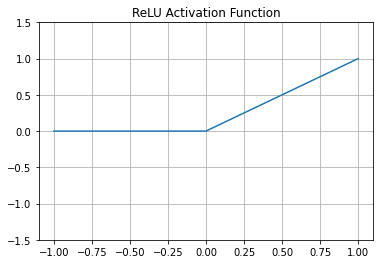

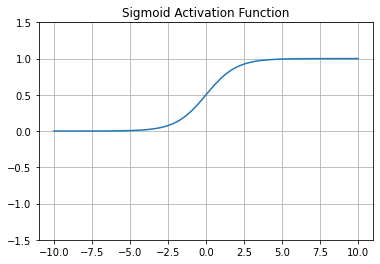

In [25]:
# we are using two different activation functions: 
# ReLU    --> Rectified Linear Unit --> max(0, x)
# Sigmoid --> No specific name      -->  1 / (1+e^-x)
# lets look at them 
def plot_activation(FUNC,start=-1,stop=1,step=5,title=None, grid=True):
    '''
    Helper function to plot the activation functions. 
    args: 
        start:type:int - defines the start value of the linspace
        stop:type:int - defines the stop value of the linspace
        step:type:int - defines the step of the linspace
        title:type:str - the title to add to the graph
    output:
        plot with the given activation function on the linspace
    '''
    ax = plt.gca()
    space1 = np.linspace(start,stop,step)
    space2 = torch.linspace(start,stop,step)
    # applying the FUNC 
    func_space = FUNC(space2).numpy()
    plt.plot(space1, func_space)
    ax.set_ylim([-1.5, 1.5])
    if grid:
        plt.grid()
    if title != None:
        plt.title(title)
    plt.show()


# showing ReLU
plot_activation(F.relu, start=-1, stop=1, step=5,title='ReLU Activation Function', grid=True)

# showing sigmoid 
plot_activation(torch.sigmoid, start=-10, stop=10, step=100,title='Sigmoid Activation Function',grid=True)

#### Loss Function and Optimizer 

We have: 
1. Our Model - Simple ANN with ReLU and Sigmoid 
2. We split our data 

What do we need now?
1. Criteria - Loss Function 
2. Optimizer - How to we update our weights --> Optimizer + Hyperparamers --> Learning Rate 


In [68]:
# define some things 
LEARNING_RATE = 0.001
# defining our criteria
criterion = nn.BCELoss() # Binary Cross Entropy -- measures the difference between two binary vectors
# optimizer --> we pass in the models or nets or Neural Networks parameters, and then define the learning rate 
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Helper Functions 

In [30]:
# we need to be able to calculate the accuracy of the model 

def get_accuracy(y, y_hat):
    '''
    Helper function to calc. the accuracy of our models output (y_hat) against the real value y. 
    '''
    pred = y_hat.ge(0.5).view(-1)
    return (y == pred).sum().float() / len(y)

# we also need a rounding helper 
def round_t(TENSOR, decimal_places=3):
    return round(TENSOR.item(), decimal_places)

#### Custom Training loop 

In [69]:
def train_lop(MODEL, CRITERIA, OPTIMIZER, EPOCHS,TEST_BATCH):
    '''
    Custom training loop to use the model, criteria and optimizer for the specified number of epochs
    '''
    for EPOCH in range(EPOCHS):
        # TRAINING MODE
        MODEL.train()
        # the prediction of the model 
        y_pred = MODEL(X_train)
        y_pred = torch.squeeze(y_pred)
        # training loss
        train_loss = CRITERIA(y_pred, y_train)
        # information from model every nth EPOCH
        if EPOCH%TEST_BATCH == 0:
            # train accuracy 
            train_acc = get_accuracy(y_train, y_pred)
            # put the moel into EVAL mode!
            MODEL.eval()
            # prediction
            test_pred = MODEL(X_test)
            # squeezing 
            test_pred = torch.squeeze(test_pred)
            #calculating our test loss 
            test_loss = CRITERIA(test_pred, y_test)
            #test accuracy 
            test_acc = get_accuracy(y_test, test_pred)
            # text to print
            train_text = f"TRAINING: EPOCH: {EPOCH} LOSS = {round_t(train_loss)} ACCURACY = {round_t(train_acc)}"
            test_text = f"TESTING: EPOCH: {EPOCH} LOSS = {round_t(test_loss)} ACCURACY = {round_t(test_acc)}"
            print(colored(text=train_text,color='red',on_color='on_grey',attrs=['bold']))
            print(colored(text=test_text,color='green',on_color='on_white',attrs=['bold']))
        # zeroing the gradients - else accumulated gradients from each iter
        OPTIMIZER.zero_grad()
        # Backprop
        train_loss.backward()
        # stepping the optimizer
        OPTIMIZER.step()

In [70]:
train_lop(model, criterion, opt, 1000,100)

TRAINING: EPOCH: 0 LOSS = 0.484 ACCURACY = 0.787
TESTING: EPOCH: 0 LOSS = 0.487 ACCURACY = 0.784
TRAINING: EPOCH: 100 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 100 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 200 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 200 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 300 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 300 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 400 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 400 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 500 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 500 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 600 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 600 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 700 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 700 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 800 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 800 LOSS = 0.48 ACCURACY = 0.79
TRAINING: EPOCH: 900 LOSS = 0.476 ACCURACY = 0.792
TESTING: EPOCH: 900 LOSS = 0.48 ACCURACY = 0.79


#### Evaluation

In [74]:
# lets look a little deeper into the model 
classes = ['No Rain','Rain']
# lets predict 
predz = model(X_test)
predz = predz.ge(0.5).view(-1)
# classification report 
cr = classification_report(y_test, predz, target_names=classes)
print(cr)

              precision    recall  f1-score   support

     No Rain       0.80      0.97      0.88     19589
        Rain       0.61      0.16      0.25      5605

    accuracy                           0.79     25194
   macro avg       0.70      0.56      0.56     25194
weighted avg       0.76      0.79      0.74     25194



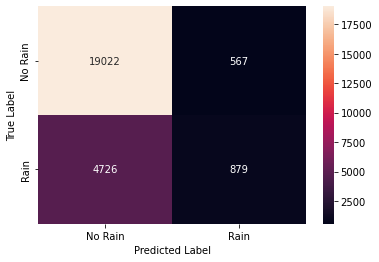

In [81]:
# lets look at a confusion matrix 
# format of (tn, fp, fn, tp)
cm = confusion_matrix(y_test, predz)
dfcm = pd.DataFrame(cm, index=classes, columns=classes)
g = sns.heatmap(dfcm,annot=True,fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [88]:
(tn, fp), (fn, tp) = confusion_matrix(y_test, predz)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 19022
False Positives: 567
False Negatives: 4726
True Positives: 879
